
Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992871.51, value end = $ 1020360.95
  Strategy "Mininum Variance Portfolio", value begin = $ 991449.41, value end = $ 1016798.86
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.33, value end = $ 1007912.05

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1031095.63, value end = $ 1011536.52
  Strategy "Mininum Variance Portfolio", value begin = $ 1024140.72, value end = $ 1014520.67
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1017368.87, value end = $ 1056054.69

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1085647.24, value end = $ 1027659.

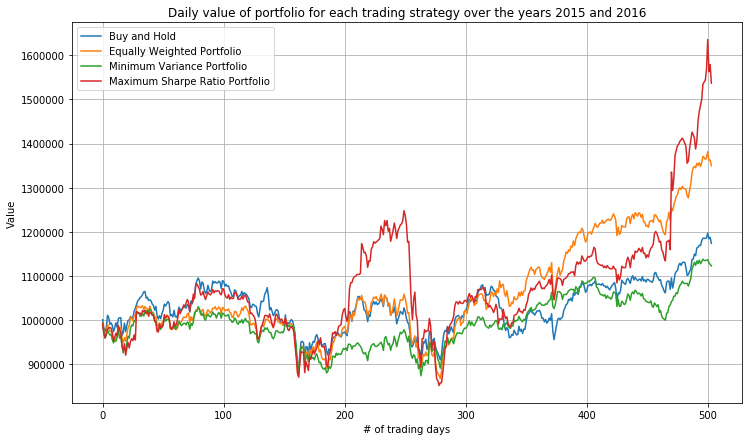

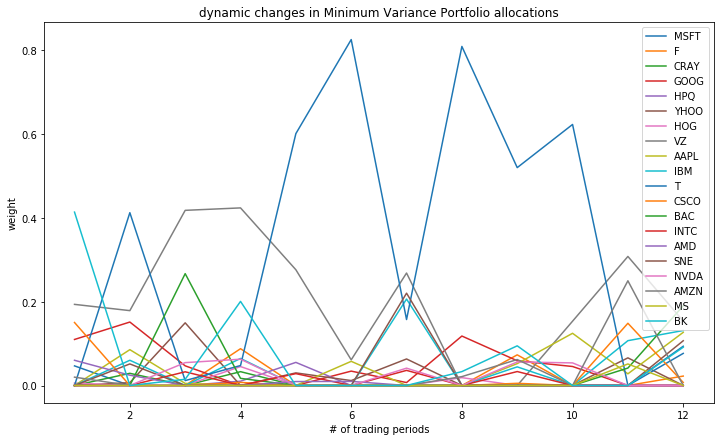

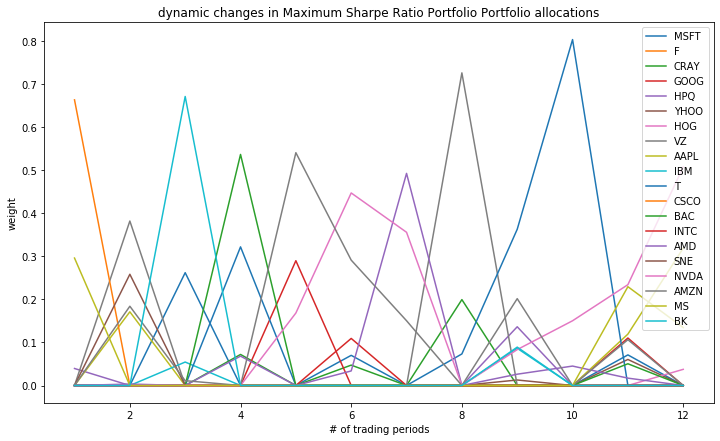

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex
# Complete the following functions
data = [[],[],[],[]]
mv = []
ms = []
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    w_i = 1/len(x_init)
    V = np.sum(cur_prices * x_init) + cash_init
    #x_i=V*w_i/v_i, where w_i=1/20, so we have x_i=V/(20*v_i), and // is use for rounding down
    x_optimal = V * w_i // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    #To make sure cash is non-negative
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V - t_f
        x_optimal = V_new * w_i // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # Calculate portfolio value。
    V = np.sum(cur_prices * x_init) + cash_init
    # number of stocks is 20.
    n = 20
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    w = []
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        w.append(cpx.solution.get_values(j))
    w_cur = np.asarray(w)
    x_optimal = w_cur * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    V = np.sum(cur_prices * x_init) + cash_init
    n = 20
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [cplex.infinity] * (n+1)
    y = []
    A = []
    for k in range(n):
        # r_rf/252 is daily risk free rate.
        A.append([[0, 1],[mu[k] - r_rf/252, 1]])
    # append -1 as a coefficient of k. since the second constraint has 21 variables in lhs 
    # while the first constraint has only 20 variables in lhs, append 0 as a coefficient to the first constraint.
    A.append([[0, 1],[0.0, -1]])
    var_names = ["w_%s" % i for i in range(1,n+2)]
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    # Add 0 at the end of Qmat
    Qmat.append([[0], [0.0]])
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        y.append(cpx.solution.get_values(j))
    y_cur = np.asarray(y)
    # w=y/k where k is the last index of y_cur
    w_cur = y_cur[:-1]/y_cur[-1]
    x_optimal = np.array(w_cur) * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 4 # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      # store portfolio values of each strategy in all periods in a list
      data[strategy] += list(p_values)
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      # minimum variance strategy
      if strategy == 2:
          # append weight of each stock by period
          mv.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
      # maximum sharpe ratio strategy
      if strategy == 3:
          # append weight of each stock by period
          ms.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.figure(figsize=(12,7))
plt.plot(data[0], label = 'Buy and Hold')
plt.plot(data[1], label = 'Equally Weighted Portfolio')
plt.plot(data[2], label = 'Minimum Variance Portfolio')
plt.plot(data[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.title('Daily value of portfolio for each trading strategy over the years 2015 and 2016')
plt.xlabel('# of trading days')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(mv).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.title('dynamic changes in Minimum Variance Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(ms).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.title('dynamic changes in Maximum Sharpe Ratio Portfolio Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')

## Only for plotting for variations of your strategies(buy and hold 1/n portfolio)


Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 999269.17, value end = $ 1027016.78
  Strategy "Equally Weighted Portfolio", value begin = $ 999264.33, value end = $ 1026925.90
  Strategy "Mininum Variance Portfolio", value begin = $ 992527.55, value end = $ 1017894.42
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990710.87, value end = $ 1008581.02

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1038379.08, value end = $ 1018645.05
  Strategy "Equally Weighted Portfolio", value begin = $ 1037736.78, value end = $ 1018045.89
  Strategy "Mininum Variance Portfolio", value begin = $ 1025241.31, value end = $ 1015612.52
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1018045.13, value end = $ 1056743.63

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1029401.31, value end = $ 993708.86

<Figure size 864x504 with 0 Axes>

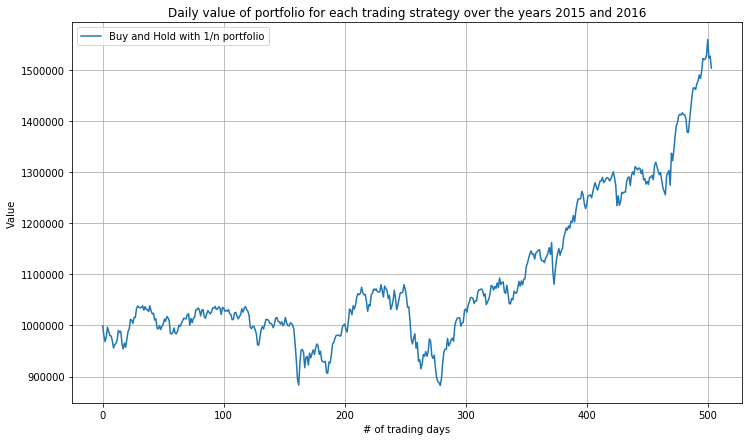

<Figure size 864x504 with 0 Axes>

In [376]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
# Complete the following functions
data = [[],[],[],[]]
mv = []
ms = []
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    w_i = 1/len(x_init)
    V = np.sum(cur_prices * x_init) + cash_init
    #x_i=V*w_i/v_i, where w_i=1/20, so we have x_i=V/(20*v_i), and // is use for rounding down
    x_optimal = V * w_i // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    #To make sure cash is non-negative
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V - t_f
        x_optimal = V_new * w_i // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # Calculate portfolio value。
    V = np.sum(cur_prices * x_init) + cash_init
    # number of stocks is 20.
    n = 20
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    w = []
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        w.append(cpx.solution.get_values(j))
    w_cur = np.asarray(w)
    x_optimal = w_cur * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    V = np.sum(cur_prices * x_init) + cash_init
    n = 20
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [cplex.infinity] * (n+1)
    y = []
    A = []
    for k in range(n):
        # r_rf/252 is daily risk free rate.
        A.append([[0, 1],[mu[k] - r_rf/252, 1]])
    # append -1 as a coefficient of k. since the second constraint has 21 variables in lhs 
    # while the first constraint has only 20 variables in lhs, append 0 as a coefficient to the first constraint.
    A.append([[0, 1],[0.0, -1]])
    var_names = ["w_%s" % i for i in range(1,n+2)]
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    # Add 0 at the end of Qmat
    Qmat.append([[0], [0.0]])
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        y.append(cpx.solution.get_values(j))
    y_cur = np.asarray(y)
    # w=y/k where k is the last index of y_cur
    w_cur = y_cur[:-1]/y_cur[-1]
    x_optimal = np.array(w_cur) * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value
w_init = 1/20
init_positions = init_value * w_init // data_prices[0,:]

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 4 # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      # store portfolio values of each strategy in all periods in a list
      data[strategy] += list(p_values)
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      # minimum variance strategy
      if strategy == 2:
          # append weight of each stock by period
          mv.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
      # maximum sharpe ratio strategy
      if strategy == 3:
          # append weight of each stock by period
          ms.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.figure(figsize=(12,7))
plt.plot(data[0], label = 'Buy and Hold with 1/n portfolio')
# plt.plot(data[1], label = 'Equally Weighted Portfolio')
# plt.plot(data[2], label = 'Mininum Variance Portfolio')
# plt.plot(data[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.title('Daily value of portfolio for each trading strategy over the years 2015 and 2016')
plt.xlabel('# of trading days')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.figure(figsize=(12,7))
# for i in range(20):
#     # Take transpose of mv to have weight by each stock in all period.
#     plt.plot(range(1, 13), np.asarray(mv).T[i].reshape(-1,1), label = list(df.columns)[i+1])
#     plt.title('dynamic changes in Mininum Variance Portfolio allocations')
#     plt.xlabel('# of trading periods')
#     plt.ylabel('weight')
#     plt.legend(loc='best')
# plt.figure(figsize=(12,7))
# for i in range(20):
#     # Take transpose of mv to have weight by each stock in all period.
#     plt.plot(range(1, 13), np.asarray(ms).T[i].reshape(-1,1), label = list(df.columns)[i+1])
#     plt.title('dynamic changes in Maximum Sharpe Ratio Portfolio Portfolio allocations')
#     plt.xlabel('# of trading periods')
#     plt.ylabel('weight')
#     plt.legend(loc='best')